In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#import captum
#from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
#from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
import math

from matplotlib.colors import LinearSegmentedColormap
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from PIL import Image

In [68]:
!pip install torch torchvision captum matplotlib==3.3.4 Flask-Compress

# Introduction to Pytorch

In [5]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # 차원 재구성
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## super
- 해당 class는 nn.Module class의 attribute들을 가지고 초기화

## Reshape() vs View
- view() : 원본 tensor와 data 공유 : deep copy
- reshape() : 원본 tensor의 복사본 혹은 view를 반환 → copy인지 view인지 모름

## forward
- model 객체를 data와 함께 호출하면 자동으로 실행

> 각 layer마다 1개씩 대응된다고 이해한 것이 맞을까?

In [6]:
net = LeNet()
print(net)                         # what does the object tell us about itself?

input = torch.rand(1, 1, 32, 32)   # stand-in for a 32x32 black & white image
print('\nImage batch shape:')
print(input.shape)

output = net(input)                # we don't call forward() directly
print('\nRaw output:')
print(output)
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape:
torch.Size([1, 1, 32, 32])

Raw output:
tensor([[ 0.0517,  0.0257,  0.0715, -0.0874,  0.0222, -0.0827, -0.0051, -0.0924,
         -0.0866,  0.0270]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird  ship horse horse


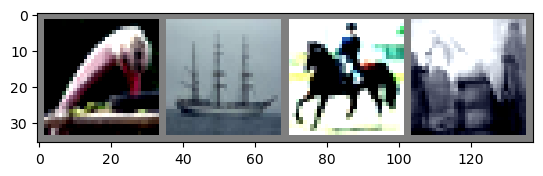

In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


  dog truck  deer  deer


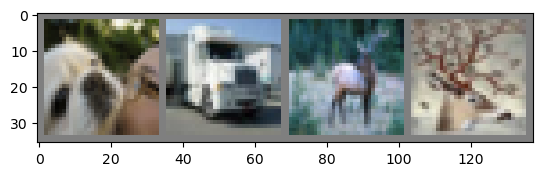

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad() # gradient 초기화

        outputs = net(inputs) # forward 계산
        loss = criterion(outputs, labels) # loss 계산
        loss.backward() # backward gradient 계산
        optimizer.step() # optimize

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.898
[1,  4000] loss: 1.582
[1,  6000] loss: 1.482
[1,  8000] loss: 1.432
[1, 10000] loss: 1.373
[1, 12000] loss: 1.354
[2,  2000] loss: 1.286
[2,  4000] loss: 1.263
[2,  6000] loss: 1.249
[2,  8000] loss: 1.231
[2, 10000] loss: 1.218
[2, 12000] loss: 1.228
Finished Training


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


# Introduction to Pytorch Tensors

In [17]:
zeros = torch.zeros(2, 3)
print(zeros)

ones = torch.ones(2, 3)
print(ones)

torch.manual_seed(1729)
random = torch.rand(2, 3)
print(random)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[1., 1., 1.],
        [1., 1., 1.]])
tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691]])


In [18]:
x = torch.empty(2, 2, 3)
print(x.shape)
print(x)

empty_like_x = torch.empty_like(x)
print(empty_like_x.shape)
print(empty_like_x)

zeros_like_x = torch.zeros_like(x)
print(zeros_like_x.shape)
print(zeros_like_x)

ones_like_x = torch.ones_like(x)
print(ones_like_x.shape)
print(ones_like_x)

rand_like_x = torch.rand_like(x)
print(rand_like_x.shape)
print(rand_like_x)

torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.]]])
torch.Size([2, 2, 3])
tensor([[[1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.]]])
torch.Size([2, 2, 3])
tensor([[[0.2332, 0.4047, 0.2162],
         [0.9927, 0.4128, 0.5938]],

        [[0.6128, 0.1519, 0.0453],
         [0.5035, 0.9978, 0.3884]]])


## torch.tensor()
- torch.tensor() : python tuple / list를 tensor로 변환
- torch.tensor()는 data의 복사본을 생성한다.

In [19]:
some_constants = torch.tensor([[3.1415926, 2.71828], [1.61803, 0.0072897]])
print(some_constants)

some_integers = torch.tensor((2, 3, 5, 7, 11, 13, 17, 19))
print(some_integers)

more_integers = torch.tensor(((2, 4, 6), [3, 6, 9]))
print(more_integers)

tensor([[3.1416, 2.7183],
        [1.6180, 0.0073]])
tensor([ 2,  3,  5,  7, 11, 13, 17, 19])
tensor([[2, 4, 6],
        [3, 6, 9]])


## torch 자료형
- torch.bool
- torch.int8
- torch.uint8 : unsigned 8 bit integer
- torch.int16
- torch.int32
- torch.int64
- torch.half : == torch.float16
- torch.float
- torch.double
- torch.bfloat : ??

In [20]:
a = torch.ones((2, 3), dtype=torch.int16)
print(a)

b = torch.rand((2, 3), dtype=torch.float64) * 20.
print(b)

c = b.to(torch.int32)
print(c)

tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.int16)
tensor([[10.8626,  2.1505, 19.6913],
        [ 0.9956,  1.4148,  5.8364]], dtype=torch.float64)
tensor([[10,  2, 19],
        [ 0,  1,  5]], dtype=torch.int32)


## Broadcasting

- pytorch operation이 bradcast를 지원하면 자동적으로 동일한 size로 확장
- 아래의 조건을 만족할 시 두 tensor는 broadcastable

1) 각 tensor는 최소한 한 차원은 가지고 있다.
2) 차원 크기에 따라 반복할 때, 뒤 쪽에서 시작하여 차원의 크기는 동일해야하고, 그 중 하나는 1이거나 존재하지 않아야한다.

In [21]:
rand = torch.rand(2, 4)
doubled = rand * (torch.ones(1, 4) * 2)

# (2, 4) * (1, 4) →???? 

print(rand)
print(doubled)

tensor([[0.0703, 0.5105, 0.9451, 0.2359],
        [0.1979, 0.3327, 0.6146, 0.5999]])
tensor([[0.1405, 1.0210, 1.8901, 0.4717],
        [0.3959, 0.6655, 1.2291, 1.1998]])


## 다양한 함수들
- torch.clamp() : a를 min, max 범주에 해당하도록 값을 변경

In [22]:
# common functions
a = torch.rand(2, 4) * 2 - 1
print('Common functions:')
print(torch.abs(a))
print(torch.ceil(a))
print(torch.floor(a))
print(torch.clamp(a, -0.5, 0.5)) # a를 min, max 범주에 해당하도록 값을 변경

# trigonometric functions and their inverses
angles = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
sines = torch.sin(angles)
inverses = torch.asin(sines)
print('\nSine and arcsine:')
print(angles)
print(sines)
print(inverses)

# bitwise operations
print('\nBitwise XOR:')
b = torch.tensor([1, 5, 11])
c = torch.tensor([2, 7, 10])
print(torch.bitwise_xor(b, c))

# comparisons:
print('\nBroadcasted, element-wise equality comparison:')
d = torch.tensor([[1., 2.], [3., 4.]])
e = torch.ones(1, 2)  # many comparison ops support broadcasting!
print(torch.eq(d, e)) # returns a tensor of type bool

# reductions:
print('\nReduction ops:')
print(torch.max(d))        # returns a single-element tensor
print(torch.max(d).item()) # extracts the value from the returned tensor
print(torch.mean(d))       # average
print(torch.std(d))        # standard deviation
print(torch.prod(d))       # product of all numbers
print(torch.unique(torch.tensor([1, 2, 1, 2, 1, 2]))) # filter unique elements

# vector and linear algebra operations
v1 = torch.tensor([1., 0., 0.])         # x unit vector
v2 = torch.tensor([0., 1., 0.])         # y unit vector
m1 = torch.rand(2, 2)                   # random matrix
m2 = torch.tensor([[3., 0.], [0., 3.]]) # three times identity matrix

print('\nVectors & Matrices:')
print(torch.cross(v2, v1)) # negative of z unit vector (v1 x v2 == -v2 x v1)
print(m1)
m3 = torch.matmul(m1, m2)
print(m3)                  # 3 times m1
print(torch.svd(m3))       # SVD 계산

Common functions:
tensor([[0.0026, 0.8793, 0.7312, 0.0413],
        [0.3730, 0.2772, 0.2987, 0.4734]])
tensor([[1., 1., 1., 1.],
        [1., -0., 1., -0.]])
tensor([[ 0.,  0.,  0.,  0.],
        [ 0., -1.,  0., -1.]])
tensor([[ 0.0026,  0.5000,  0.5000,  0.0413],
        [ 0.3730, -0.2772,  0.2987, -0.4734]])

Sine and arcsine:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7854, 1.5708, 0.7854])

Bitwise XOR:
tensor([3, 2, 1])

Broadcasted, element-wise equality comparison:
tensor([[ True, False],
        [False, False]])

Reduction ops:
tensor(4.)
4.0
tensor(2.5000)
tensor(1.2910)
tensor(24.)
tensor([1, 2])

Vectors & Matrices:
tensor([ 0.,  0., -1.])
tensor([[0.4762, 0.0548],
        [0.2024, 0.5731]])
tensor([[1.4286, 0.1643],
        [0.6073, 1.7192]])
torch.return_types.svd(
U=tensor([[-0.5102, -0.8600],
        [-0.8600,  0.5102]]),
S=tensor([2.0017, 1.1771]),
V=tensor([[-0.6251, -0.7805],
        [-0.7805,  0.6251]]))


In [23]:
a = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
print('a:')
print(a)
print(torch.sin(a))   # this operation creates a new tensor in memory
print(a)              # a has not changed

b = torch.tensor([0, math.pi / 4, math.pi / 2, 3 * math.pi / 4])
print('\nb:')
print(b)
print(torch.sin_(b))  # note the underscore
print(b)              # b has changed

a:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7854, 1.5708, 2.3562])

b:
tensor([0.0000, 0.7854, 1.5708, 2.3562])
tensor([0.0000, 0.7071, 1.0000, 0.7071])
tensor([0.0000, 0.7071, 1.0000, 0.7071])


## Altering
- fucn_() : 원본의 값을 교체
- clone() : history 유지, new memory 할당
- clone().detach() : 새 tensor를 메모리에 할당, 기존 계산 그래프와 끊음
- detach().clone() : 기울기가 계산되지 않은 tensor를 만들고 새로운 메모리에 할당
- 후자가 조금 더 빠르다고 한다.

In [24]:
a = torch.ones(2, 2)
b = a

a[0][1] = 561  # we change a...
print(b)       # ...and b is also altered

a = torch.ones(2, 2)
b = a.clone()

assert b is not a      # different objects in memory...
print(torch.eq(a, b))  # ...but still with the same contents!

a[0][1] = 561          # a changes...
print(b)               # ...but b is still all ones

a = torch.rand(2, 2, requires_grad=True) # turn on autograd
print(a)

b = a.clone()
print(b)

c = a.detach().clone()
print(c)

print(a)

tensor([[  1., 561.],
        [  1.,   1.]])
tensor([[True, True],
        [True, True]])
tensor([[1., 1.],
        [1., 1.]])
tensor([[0.7191, 0.4067],
        [0.7301, 0.6276]], requires_grad=True)
tensor([[0.7191, 0.4067],
        [0.7301, 0.6276]], grad_fn=<CloneBackward0>)
tensor([[0.7191, 0.4067],
        [0.7301, 0.6276]])
tensor([[0.7191, 0.4067],
        [0.7301, 0.6276]], requires_grad=True)


In [25]:
if torch.cuda.is_available():
    print('We have a GPU!')
else:
    print('Sorry, CPU only.')

# 저는 안 좋은 것이긴 해도 GPU가 있어요...무시하지 말아주세요...

Sorry, CPU only.


In [26]:
if torch.cuda.is_available():
    gpu_rand = torch.rand(2, 2, device='cuda')
    print(gpu_rand)
else:
    print('Sorry, CPU only.')

Sorry, CPU only.


## dimension
- squeeze() : 차원이 1인 차원을 제거, 설정하지 않으면 1인 차원 모두 제거, 설정시 그 차원만 제거 → batch가 1인 차원도 제거해버릴 수 있으니 조심...
- unsqueeze : 1인 차원을 생성, 어느 차원에 생성할 지 지정해야한다.

In [27]:
a = torch.rand(3, 226, 226)
b = a.unsqueeze(0)

print(a.shape)
print(b.shape)

a = torch.ones(4, 3, 2)
b = torch.rand(   3)     # trying to multiply a * b will give a runtime error
c = b.unsqueeze(1)       # change to a 2-dimensional tensor, adding new dim at the end
print(c.shape)
print(a * c)             # broadcasting works again!

torch.Size([3, 226, 226])
torch.Size([1, 3, 226, 226])
torch.Size([3, 1])
tensor([[[0.9646, 0.9646],
         [0.1726, 0.1726],
         [0.5225, 0.5225]],

        [[0.9646, 0.9646],
         [0.1726, 0.1726],
         [0.5225, 0.5225]],

        [[0.9646, 0.9646],
         [0.1726, 0.1726],
         [0.5225, 0.5225]],

        [[0.9646, 0.9646],
         [0.1726, 0.1726],
         [0.5225, 0.5225]]])


# The Fundamentals of Autograd

## Autograd
- gradient를 쉽게 계산해준다.
- loss를 모든 input에 대해 0에 가깝게 만드는 과정을 도와준다.
- loss는 input에 대한 것이 아닌, output(y)에 대해 파생되는 것이다.
- Chain rule에 의해 gradient를 계산
- 각 gradient function은 local gradient 곱의 합이다.
- requires_grad 설정

In [28]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


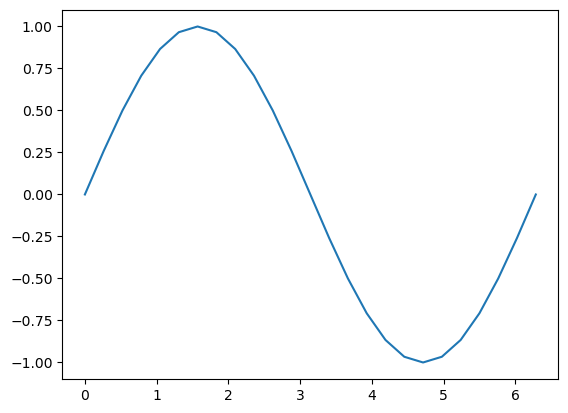

In [29]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

In [30]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


In [31]:
c = 2 * b
print(c)

d = c + 1
print(d)

out = d.sum()
print(out)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)
tensor(25., grad_fn=<SumBackward0>)


In [32]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x0000013BCA470F70>, 0), (None, 0))
((<SinBackward0 object at 0x0000013BD519B790>, 0), (None, 0))
((<AccumulateGrad object at 0x0000013BCA470700>, 0),)
()

c:

b:

a:
None


tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


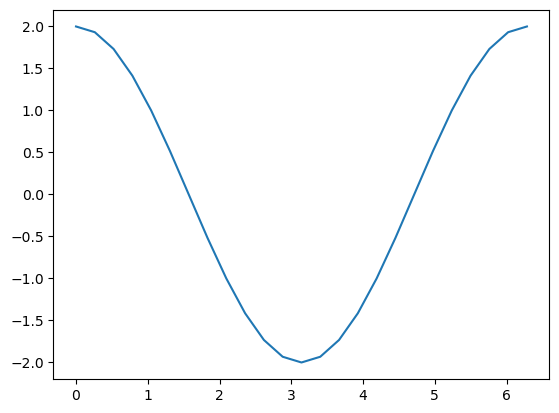

In [33]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())
# graph gradient graph

In [34]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
b = torch.sin(a)
c = 2 * b
d = c + 1
out = d.sum()

## Autograd in training

In [35]:
BATCH_SIZE = 16
DIM_IN = 1000
HIDDEN_SIZE = 100
DIM_OUT = 10

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.layer1 = torch.nn.Linear(1000, 100)
        self.relu = torch.nn.ReLU()
        self.layer2 = torch.nn.Linear(100, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

some_input = torch.randn(BATCH_SIZE, DIM_IN, requires_grad=False)
ideal_output = torch.randn(BATCH_SIZE, DIM_OUT, requires_grad=False)

model = TinyModel()

In [36]:
print(model.layer2.weight[0][0:10]) # just a small slice
print(model.layer2.weight.grad)

tensor([-0.0362,  0.0537, -0.0847,  0.0336,  0.0515,  0.0535,  0.0736, -0.0530,
         0.0315, -0.0863], grad_fn=<SliceBackward0>)
None


In [37]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

prediction = model(some_input)

loss = (ideal_output - prediction).pow(2).sum()
print(loss)

tensor(182.5238, grad_fn=<SumBackward0>)


In [38]:
loss.backward()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0362,  0.0537, -0.0847,  0.0336,  0.0515,  0.0535,  0.0736, -0.0530,
         0.0315, -0.0863], grad_fn=<SliceBackward0>)
tensor([-0.4058, -1.1056, -7.2330, -1.7092,  1.0408,  1.5486, -0.9126,  5.7596,
         1.2251, -1.2476])


In [39]:
optimizer.step()
print(model.layer2.weight[0][0:10])
print(model.layer2.weight.grad[0][0:10])

tensor([-0.0358,  0.0549, -0.0775,  0.0353,  0.0505,  0.0520,  0.0745, -0.0588,
         0.0303, -0.0850], grad_fn=<SliceBackward0>)
tensor([-0.4058, -1.1056, -7.2330, -1.7092,  1.0408,  1.5486, -0.9126,  5.7596,
         1.2251, -1.2476])


In [40]:
print(model.layer2.weight.grad[0][0:10])

for i in range(0, 5):
    prediction = model(some_input)
    loss = (ideal_output - prediction).pow(2).sum()
    loss.backward()

print(model.layer2.weight.grad[0][0:10])

optimizer.zero_grad(set_to_none=False)

print(model.layer2.weight.grad[0][0:10])

tensor([-0.4058, -1.1056, -7.2330, -1.7092,  1.0408,  1.5486, -0.9126,  5.7596,
         1.2251, -1.2476])
tensor([ -7.7376, -15.2504, -25.6537, -16.7443,   0.3732,  -4.8263,  -3.0942,
         35.4228,   6.1900,  -1.1203])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


- zero_grad를 하지 않으면 gradient 값이 커지게 된다. 즉, 다음 train batch 시작 전 gradient를 0으로 초기화하는 작업을 진행해야한다.

## Autograd on/off

In [41]:
a = torch.ones(2, 3, requires_grad=True)
print(a)

b1 = 2 * a
print(b1)

a.requires_grad = False
b2 = 2 * a
print(b2)

tensor([[1., 1., 1.],
        [1., 1., 1.]], requires_grad=True)
tensor([[2., 2., 2.],
        [2., 2., 2.]], grad_fn=<MulBackward0>)
tensor([[2., 2., 2.],
        [2., 2., 2.]])


In [42]:
a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = a + b
print(c1)

with torch.no_grad():
    c2 = a + b

print(c2)

c3 = a * b
print(c3)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])
tensor([[6., 6., 6.],
        [6., 6., 6.]], grad_fn=<MulBackward0>)


In [43]:
def add_tensors1(x, y):
    return x + y

@torch.no_grad()
def add_tensors2(x, y):
    return x + y


a = torch.ones(2, 3, requires_grad=True) * 2
b = torch.ones(2, 3, requires_grad=True) * 3

c1 = add_tensors1(a, b)
print(c1)

c2 = add_tensors2(a, b)
print(c2)

tensor([[5., 5., 5.],
        [5., 5., 5.]], grad_fn=<AddBackward0>)
tensor([[5., 5., 5.],
        [5., 5., 5.]])


In [44]:
x = torch.rand(5, requires_grad=True)
y = x.detach()

print(x)
print(y)

tensor([0.2415, 0.0564, 0.6263, 0.5639, 0.4520], requires_grad=True)
tensor([0.2415, 0.0564, 0.6263, 0.5639, 0.4520])


## Autograd profiler
- autograd는 모든 단계를 저장하고 있다. profiler를 통해 확인이 가능하다.

In [45]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
torch.sin_(a)

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    run_on_gpu = True

x = torch.randn(2, 3, requires_grad=True)
y = torch.rand(2, 3, requires_grad=True)
z = torch.ones(2, 3, requires_grad=True)

with torch.autograd.profiler.profile(use_cuda=run_on_gpu) as prf:
    for _ in range(1000):
        z = (z / x) * y

print(prf.key_averages().table(sort_by='self_cpu_time_total'))

# Building Models with Pytorch

In [46]:
class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        self.linear1 = torch.nn.Linear(100, 200)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 10)
        self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

tinymodel = TinyModel()

print('The model:')
print(tinymodel)

print('\n\nJust one layer:')
print(tinymodel.linear2)

print('\n\nModel params:')
for param in tinymodel.parameters():
    print(param)

print('\n\nLayer params:')
for param in tinymodel.linear2.parameters():
    print(param)

The model:
TinyModel(
  (linear1): Linear(in_features=100, out_features=200, bias=True)
  (activation): ReLU()
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)


Just one layer:
Linear(in_features=200, out_features=10, bias=True)


Model params:
Parameter containing:
tensor([[-0.0573, -0.0052, -0.0554,  ...,  0.0569, -0.0231, -0.0148],
        [-0.0313, -0.0530, -0.0148,  ..., -0.0828, -0.0927,  0.0914],
        [ 0.0108,  0.0758, -0.0037,  ...,  0.0260,  0.0023,  0.0563],
        ...,
        [-0.0950,  0.0197, -0.0981,  ...,  0.0453, -0.0367,  0.0834],
        [ 0.0778, -0.0113, -0.0731,  ...,  0.0102, -0.0361, -0.0478],
        [ 0.0990,  0.0890,  0.0780,  ...,  0.0440,  0.0648, -0.0008]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0394,  0.0072,  0.0679, -0.0619, -0.0594, -0.0047, -0.0390, -0.0102,
        -0.0842, -0.0374,  0.0552,  0.0543, -0.0294,  0.0167, -0.0217, -0.0830,
         0.0820,  0.0521,  0.0029, -0.08

## Linear layer
- n차원 input을 m차원 output으로 변환
- 행렬의 크기가 바뀌어도 행렬의 성질이 변하지 않는다. → 선형변환 전/후 연산 결과는 동일해야한다.

In [47]:
lin = torch.nn.Linear(3, 2)
x = torch.rand(1, 3)
print('Input:')
print(x)

print('\n\nWeight and Bias parameters:')
for param in lin.parameters():
    print(param)

y = lin(x)
print('\n\nOutput:')
print(y)

Input:
tensor([[0.9533, 0.0585, 0.6771]])


Weight and Bias parameters:
Parameter containing:
tensor([[ 0.3166,  0.2901, -0.3262],
        [ 0.2931, -0.2510, -0.2691]], requires_grad=True)
Parameter containing:
tensor([-0.3051, -0.1316], requires_grad=True)


Output:
tensor([[-0.2072, -0.0491]], grad_fn=<AddmmBackward0>)


## Convolution layer
- Conv layer 첫 번째 인자 : input channel (ex. RGB 사진 : 3)
- Conv layer 두 번째 인자 : output feature (ex. 6 = output = 6)
- Conv layer 세 번째 인자 : window(kernel) size (ex. 5 = 5 * 5 kernel )

In [48]:
class LeNet(torch.nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Recurrent layer
- LSTM, GRU... 주로 시계열 데이터 / 자연어 등
- sequence에 대해 hidden state를 유지하며 진행
- vocab_size : 입력 어휘 단어 수 (one-hot vector)
- tagset_size : output set의 tag 수
- embedding_dim : vocab에 대한 embedding size
- hidden_dim : lstm memory size

In [49]:
class LSTMTagger(torch.nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = torch.nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

## Transformers
- 추후 공부해보기

## Data Manipulation layer

### Maxpooling
- tensor의 크기를 줄인다.
- 이 외에도 average pooling 등이 존재

In [50]:
my_tensor = torch.rand(1, 6, 6)
print(my_tensor)

maxpool_layer = torch.nn.MaxPool2d(3)
print(maxpool_layer(my_tensor))

tensor([[[0.8507, 0.9433, 0.1999, 0.3773, 0.8068, 0.2843],
         [0.6769, 0.5166, 0.3126, 0.7104, 0.0595, 0.0766],
         [0.5700, 0.3795, 0.6014, 0.7825, 0.6129, 0.1244],
         [0.1728, 0.0317, 0.3130, 0.9733, 0.4610, 0.9418],
         [0.0620, 0.2252, 0.4070, 0.0830, 0.5298, 0.6596],
         [0.7779, 0.7025, 0.9647, 0.8481, 0.3717, 0.3629]]])
tensor([[[0.9433, 0.8068],
         [0.9647, 0.9733]]])


### Normalization
- gradient exploding/vanishing 방지
- 학습 속도 향상
- 편향 줄이기 등

In [51]:
my_tensor = torch.rand(1, 4, 4) * 20 + 5
print(my_tensor)

print(my_tensor.mean())

norm_layer = torch.nn.BatchNorm1d(4)
normed_tensor = norm_layer(my_tensor)
print(normed_tensor)

print(normed_tensor.mean())

tensor([[[10.3878, 16.3952,  7.4842, 13.1639],
         [11.4669, 24.0686, 21.3807, 14.7114],
         [12.5586, 20.4574, 24.9323, 22.5879],
         [18.1548, 13.9798,  7.7083, 18.7162]]])
tensor(16.1346)
tensor([[[-0.4453,  1.3746, -1.3250,  0.3957],
         [-1.2771,  1.2219,  0.6889, -0.6337],
         [-1.6287,  0.0695,  1.0316,  0.5276],
         [ 0.7988, -0.1500, -1.5752,  0.9264]]],
       grad_fn=<NativeBatchNormBackward0>)
tensor(-1.7136e-07, grad_fn=<MeanBackward0>)


### Dropout layer
- 일정 확률로 뉴런을 제거
- 특정 feature만 집중적으로 학습하는 것을 방지 (overfitting 방지)

In [52]:
my_tensor = torch.rand(1, 4, 4)

dropout = torch.nn.Dropout(p=0.4)
print(dropout(my_tensor))
print(dropout(my_tensor))

tensor([[[0.0000, 0.0000, 1.2421, 0.0000],
         [0.0000, 0.6510, 1.5140, 0.0000],
         [0.0000, 0.8572, 0.7014, 1.4476],
         [0.0000, 1.0432, 1.5562, 0.0000]]])
tensor([[[0.6188, 0.0000, 1.2421, 0.6964],
         [0.0000, 0.6510, 1.5140, 0.7427],
         [0.0576, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 1.5562, 0.3549]]])


## Activation Function & Loss function

# Tensorboard
- 머신러닝에 필요한 시각화 및 도구 제공
- 손실 및 정확도와 같은 항목 추적 및 시각화
- 모델 그래프 시각화
- 시간의 경과에 따라 달라지는 weight, bias, 기타 tensor 히스토그램 확인
- TensorFlow 프로그램 profiling

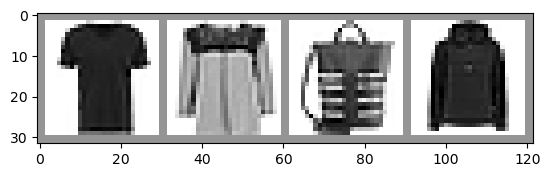

In [53]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
validation_set = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

training_loader = torch.utils.data.DataLoader(training_set,
                                              batch_size=4,
                                              shuffle=True,
                                              num_workers=2)


validation_loader = torch.utils.data.DataLoader(validation_set,
                                                batch_size=4,
                                                shuffle=False,
                                                num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)

In [54]:
writer = SummaryWriter('runs/fashion_mnist_experiment_1')
writer.add_image('Four Fashion-MNIST Images', img_grid)
writer.flush()

In [55]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [56]:
print(len(validation_loader))
for epoch in range(1):
    running_loss = 0.0

    for i, data in enumerate(training_loader, 0):
        # basic training loop
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:   
            print('Batch {}'.format(i + 1))
 
            running_vloss = 0.0

            net.train(False) 
            for j, vdata in enumerate(validation_loader, 0):
                vinputs, vlabels = vdata
                voutputs = net(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()
            net.train(True)

            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(validation_loader)

            writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : avg_loss, 'Validation' : avg_vloss },
                            epoch * len(training_loader) + i)

            running_loss = 0.0
print('Finished Training')

writer.flush()

2500
Batch 1000
Batch 2000
Batch 3000
Batch 4000
Batch 5000
Batch 6000
Batch 7000
Batch 8000
Batch 9000
Batch 10000
Batch 11000
Batch 12000
Batch 13000
Batch 14000
Batch 15000
Finished Training


In [57]:
dataiter = iter(training_loader)
images, labels = next(dataiter)

writer.add_graph(net, images)
writer.flush()

In [58]:
def select_n_random(data, labels, n=100):
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

images, labels = select_n_random(training_set.data, training_set.targets)

class_labels = [classes[label] for label in labels]

features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, label_img=images.unsqueeze(1))
writer.flush()
writer.close()

AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

# Training with pytorch

In [59]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Pullover  T-shirt/top  Bag  Trouser


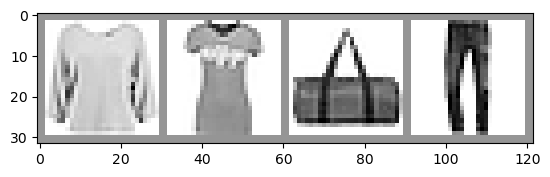

In [60]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [61]:
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [62]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.4511, 0.4274, 0.0244, 0.1724, 0.8423, 0.9008, 0.0835, 0.2933, 0.8210,
         0.9050],
        [0.6015, 0.5628, 0.2343, 0.7009, 0.5464, 0.6957, 0.4126, 0.5487, 0.5774,
         0.9338],
        [0.0816, 0.9957, 0.3180, 0.3508, 0.7750, 0.1982, 0.9364, 0.2251, 0.7173,
         0.2039],
        [0.7696, 0.0150, 0.2728, 0.1838, 0.3021, 0.0384, 0.4185, 0.5690, 0.5157,
         0.0326]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2965683937072754


In [63]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [64]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [65]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.000756495773792
  batch 2000 loss: 1.0029250657781958
  batch 3000 loss: 0.7716421835385263
  batch 4000 loss: 0.6780801229225472
  batch 5000 loss: 0.5939130934290587
  batch 6000 loss: 0.564078380914405
  batch 7000 loss: 0.5651655988474377
  batch 8000 loss: 0.5035909406099236
  batch 9000 loss: 0.5032740121481475
  batch 10000 loss: 0.46591344086738534
  batch 11000 loss: 0.46422862087003886
  batch 12000 loss: 0.4703911993777801
  batch 13000 loss: 0.4574316748706042
  batch 14000 loss: 0.4431960858716629
  batch 15000 loss: 0.415035941894399
LOSS train 0.415035941894399 valid 0.42039555311203003
EPOCH 2:
  batch 1000 loss: 0.43602111032698304
  batch 2000 loss: 0.40372175794193754
  batch 3000 loss: 0.4009909667420143
  batch 4000 loss: 0.37883787710312755
  batch 5000 loss: 0.3689136817608378
  batch 6000 loss: 0.39375343419535785
  batch 7000 loss: 0.362183744858834
  batch 8000 loss: 0.37500043036579156
  batch 9000 loss: 0.3739519485779747
  batc

# Model understanding with Captum
- explainable model
- Feature Attribution : output을 input의 관점에서 설명
- Layer Attribution : hidden layer의 activity
- Neuron Attribution : 단일 뉴런의 activity

## Attribution Algorithm
- gradient-based : backward propagation
- perturbation-based : input에 대한 output의 변화

## Captum
- image, text, model type등에 대해 시각화하는 API

# Save & Load Models
- model.eval()을 dropout, batch normalization layer 전에 해야한다. 일관되지 않은 결과가 나올 수 있다.

In [73]:
model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\82108/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [74]:
model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [75]:
torch.save(model, 'model.pth')

In [76]:
model = torch.load('model.pth')

In [77]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1